<a href="https://colab.research.google.com/github/willhorgalcon/publicrep/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!unzip -o X.zip
!unzip -o y.zip

Archive:  X.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of X.zip or
        X.zip.zip, and cannot find X.zip.ZIP, period.
Archive:  y.zip
  inflating: y/00001.bmp             
  inflating: y/00002.bmp             
  inflating: y/00003.bmp             
  inflating: y/00004.bmp             
  inflating: y/00005.bmp             
  inflating: y/00006.bmp             
  inflating: y/00007.bmp             
  inflating: y/00008.bmp             
  inflating: y/00009.bmp             
  inflating: y/00010.bmp             
  inflating: y/00011.bmp             
  inflating: y/00012.bmp             
  inflating: y/00013.bmp             
  inflating: y/00014.bmp             
  inflating: y/00015.bmp             
  inflating: y/00016.bmp        

In [6]:
import os
input_dir = "X"
target_dir = "y"
input_img_paths = sorted( [os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
  if fname.endswith(".jpg")])
target_paths = sorted( [os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
 if fname.endswith(".png") and not fname.startswith(".")])


FileNotFoundError: [Errno 2] No such file or directory: 'X'

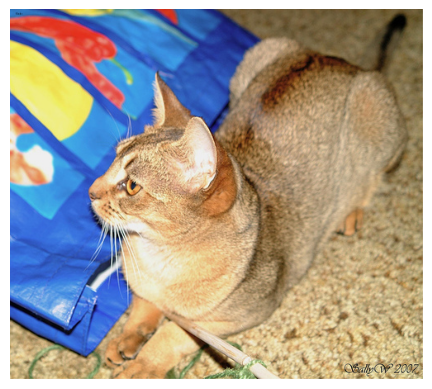

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

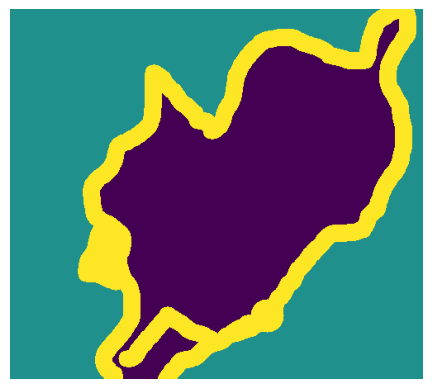

In [ ]:
def display_target(target_array):
 normalized_array = (target_array.astype("uint8") - 1) * 127
 plt.axis("off")
 plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
 return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
 img = img_to_array(
 load_img(path, target_size=img_size, color_mode="grayscale"))
 img = img.astype("uint8") - 1
 return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
 inputs = keras.Input(shape=img_size + (3,))
 x = layers.Rescaling(1./255)(inputs)
 x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
 x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 256, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 128, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 64, 3, activation="relu", padding="same", strides=2)(x)
 outputs = layers.Conv2D(num_classes, 3, activation="softmax",
padding="same")(x)
 model = keras.Model(inputs, outputs)
 return model
model = get_model(img_size=img_size, num_classes=3)
model.summary()

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
 keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
 save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
 epochs=50,
 callbacks=callbacks,
 batch_size=64,
 validation_data=(val_input_imgs, val_targets))